In [114]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
import pickle

# Func & Load

In [115]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        meta = meta.head(1) # multisession, only keep one metadata
    return meta

In [116]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
print(meta)

dir_name = root_path + 'mat/'
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'resp_base_trialwise' + '.mat'))
# dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] # do not subtract baseline here: stim resp will be compared to base resp
dfof_tg_trial = dfof_trialwise['dfof_tg_trial']

   mouse           date area  num
0   1350  211222_caiman   V1  2.0


In [117]:
dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

(dict_keys(['__header__', '__version__', '__globals__', 'dfof_ad_trial', 'dfof_base2_trial', 'dfof_base_trial', 'dfof_tg_trial']),
 (324, 30),
 (49, 1))

# One way anova
for each cell, base = [ntrial, 1], stim_resp = [ntrial_stim, nstim].  
base vs stim anova or kruskal wallis

In [118]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]

p_anova = np.ones((ncell, 1)) * np.nan
p_kruskal = np.ones((ncell, 1)) * np.nan
# p_alexandergovern = np.ones((ncell, 1)) * np.nan

for icell in tqdm(np.arange(ncell)):
    base_cell = np.concatenate([dfof_trialwise['dfof_base_trial'][icell, stim] for stim in range(nstim)])
    stim_cell = [] 
    for istim in np.arange(nstim):
        stim_cell.append(np.array(dfof_ad_trial[icell, istim]).flatten())
    
    _, p_anova_cell = stats.f_oneway(np.array(base_cell).flatten(), *stim_cell)
    p_anova[icell] = p_anova_cell
    _, p_kruskal_cell = stats.kruskal(np.array(base_cell).flatten(), *stim_cell)
    p_kruskal[icell] = p_kruskal_cell
    # _, p_alexandergovern_cell = stats.alexandergovern(np.array(base_cell).flatten(), *stim_cell)
    # p_alexandergovern[icell] = p_alexandergovern_cell
    # print(stats.alexandergovern(np.array(base_cell).flatten(), *stim_cell)) # alexandergovern result cannot extract p-value

100%|██████████| 324/324 [00:00<00:00, 580.51it/s]


array([85])

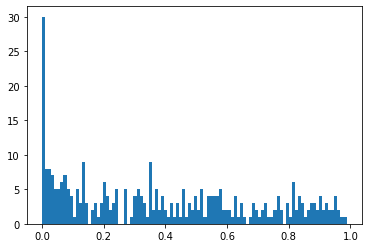

In [119]:
plt.hist(p_anova, 100);
sum(p_anova < 0.1)

array([103])

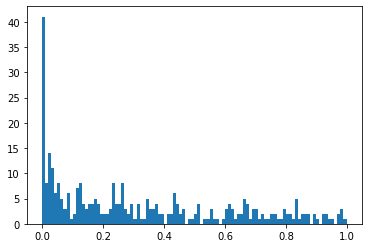

In [120]:
plt.hist(p_kruskal, 100);
sum(p_kruskal < 0.1)

# One sided t test
for each cell, base = [ntrial_stim, 1], stim_resp = [ntrial_stim, nstim].  
base vs stim : 1 sided t test

In [127]:
p_ttest = np.ones((ncell, nstim)) * np.nan

for icell in tqdm(np.arange(ncell)):
    for istim in np.arange(nstim):
        base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
        stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
        
        _, p_ttest_i = stats.ttest_ind(base_cell.flatten(), stim_cell.flatten(), equal_var=False, alternative='less')
        p_ttest[icell, istim] = p_ttest_i

100%|██████████| 324/324 [00:01<00:00, 197.88it/s]


In [137]:
print(0.05*324)
sum(p_ttest < 0.05)#.mean()

16.2


array([ 1, 14, 17,  8,  6, 19, 12, 17, 23,  6, 17,  0, 13,  8, 24, 11, 15,
       21, 18, 18,  6, 20, 10, 14,  8, 11, 16, 14,  9, 12])

In [134]:
# sum(p_ttest.T < 0.05)
(sum(p_ttest.T < 0.05) > 0).sum()

151

# Amp thresh
trial averaged stim resp > 10%

In [141]:
evoked = np.ones((ncell, nstim)) * np.nan

for icell in tqdm(np.arange(ncell)):
    for istim in np.arange(nstim):
        base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
        stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
        
        evoked_cell = (stim_cell - base_cell) / (base_cell + 1e-7)
        evoked_i = np.mean(evoked_cell, axis=0) # trial averaged evoked resp
        evoked[icell, istim] = evoked_i

100%|██████████| 324/324 [00:00<00:00, 2945.05it/s]


In [144]:
sum(evoked > 0.1), sum(evoked > 0.1).mean(), (sum(evoked.T > 0.1) > 0).sum()

(array([ 96, 102,  94, 101, 108, 111, 101, 105, 103, 109,  94, 115,  98,
        103, 109, 100, 104,  91,  96, 110, 108, 114, 112, 101,  95,  94,
        104,  99,  87, 110]),
 102.46666666666667,
 324)

# AND gate
according to Ohki 2020  
anova -> visually driven cells,  
t test -> certain image responsive cells,  
amp thresh -> lower false positive rate

In [145]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]

p_anova = np.ones((ncell, 1)) * np.nan
p_kruskal = np.ones((ncell, 1)) * np.nan
p_ttest = np.ones((ncell, nstim)) * np.nan
evoked = np.ones((ncell, nstim)) * np.nan

for icell in tqdm(np.arange(ncell)):
    base_cell_anova = np.concatenate([dfof_trialwise['dfof_base_trial'][icell, stim] for stim in range(nstim)])
    stim_cell_anova = [] 
    for istim in np.arange(nstim):
        stim_cell_anova.append(np.array(dfof_ad_trial[icell, istim]).flatten())

        base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
        stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
        _, p_ttest_i = stats.ttest_ind(base_cell.flatten(), stim_cell.flatten(), equal_var=False, alternative='less')
        p_ttest[icell, istim] = p_ttest_i

        evoked_cell = (stim_cell - base_cell) / (base_cell + 1e-7)
        evoked_i = np.mean(evoked_cell, axis=0) # trial averaged evoked resp
        evoked[icell, istim] = evoked_i
    
    _, p_anova_cell = stats.f_oneway(np.array(base_cell_anova).flatten(), *stim_cell_anova)
    p_anova[icell] = p_anova_cell
    _, p_kruskal_cell = stats.kruskal(np.array(base_cell_anova).flatten(), *stim_cell_anova)
    p_kruskal[icell] = p_kruskal_cell

100%|██████████| 324/324 [00:02<00:00, 142.82it/s]


In [229]:
# visually driven cells: pass (anova OR kruskal) AND amp threshold for >=1 image
p_sig = 0.05
vis_driven = ((p_anova < p_sig) | (p_kruskal < p_sig)) & (sum(evoked.T > 0.1) > 0).reshape(-1, 1)
print(f'{vis_driven.sum()} cells are visually driven, \n\
    proportion {np.round(vis_driven.sum()/ncell, 2)} out of {ncell} cells')

# cells responsive to image i: pass visually driven (anova OR kruskal) AND t-test AND amp threshold for *this* image
img_driven = vis_driven & (p_ttest < p_sig) & (evoked > 0.1)
print(f'{img_driven.sum()} cells are image driven - with overlap between images, \n\
    proportion {np.round(img_driven.sum()/ncell, 2)} out of {ncell} cells. \n\
    1-30 image evokes resp from {np.sum(img_driven, axis=0)} cells')

95 cells are visually driven, 
    proportion 0.29 out of 324 cells
90 cells are image driven - with overlap between images, 
    proportion 0.28 out of 324 cells. 
    1-30 image evokes resp from [0 6 1 1 1 7 4 3 8 1 2 0 2 1 4 3 3 5 4 5 0 7 3 5 3 0 5 2 1 3] cells


In [222]:
with open('vis_img_driven.pickle', 'wb') as handle:
    pickle.dump(img_driven, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(vis_driven, handle, protocol=pickle.HIGHEST_PROTOCOL)
